# CS 109A/STAT 121A/AC 209A/CSCI E-109A

## Standard Section 9: Random Forests, Adaboost, and the Bias-Variance Tradeoff

**Harvard University**<br/>
**Fall 2017**<br/>
**Section Leaders: Albert Wu, Nathaniel Burbank<br/>**
**Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine** 

<center>**Download this notebook from the CS109 repo or here:**</center>
<center>**http://bit.ly/109_S9T**</center>

This section will work with a spam email dataset. Our ultimate goal is to be able to build models so that we can predict whether an email is spam or not spam based on word characteristics within each email. We will cover the Adaboost and Random Forest methods and allow you to apply it to the homework.

Specifically, we will: 
    
    1. Load in the spam dataset and get a feel for the features of the dataset.
    2. Fit a simple Decision Tree model and discover what the accuracy rate is.
    3. Fit the Random Forest model and use cross validation to find the optimal value for the number of predictors. 
    4. Use the Adaboost method to see if we can get possibly better results.
    5. Introduce ourselves to the idea of the bias-variance tradeoff and apply it to understanding how well our two methods above apply to our dataset.

In [116]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.learning_curve import learning_curve


# Review: Bias Variance Tradeoff

A central notion underlying what we've been learning in lectures and sections so far is the trade-off between overfitting and underfitting. If you remember back to Homework 3, we had a model that seemed to represent our data accurately. However, we saw that as we made it more and more accurate on the training set, it did not generalize well to unobserved data.

As a different example, in face recognition algorithms, such as that on the iPhone X, a too-accurate model would be unable to identity someone who styled their hair differently that day. The reason is that our model may learn irrelevant features in the training data. On the contrary, an insufficiently trained model would not generalize well either. For example, it was recently reported that a face mask could sufficiently fool the iPhone X.

A widely used solution in statistics to reduce overfitting consists of adding structure to the model, with something like regularization. This method favors simpler models during training.

The bias-variance dilemma is closely related. The **bias** of a model quantifies how precise a model is across training sets. The **variance** quantifies how sensitive the model is to small changes in the training set. A **robust** model is not overly sensitive to small changes. The dilemma involves minimizing both bias and variance; we want a precise and robust model. Simpler models tend to be less accurate but more robust. Complex models tend to be more accurate but less robust.

<img src="https://raw.githubusercontent.com/albertw1/data/master/Low-High-Variances-Biases.png" width="300" height="300"/>

As an example of the bias variance tradeoff, the following picture was taken from a machine learning textbook. It represents throwing darts as a target and the ultimate goal is to hit a bullseye. 

The top left plot represents the ideal situation where we have low bias and low variance. In layman's terms, we are able to consistently hit the bullseye while having a low spread around the target. The spread indicates in a way how efficiently we are able to hit the bullseye. 

The top right plot indicates when the bias is low and the variance is high. Why is the bias low? Think about taking the average of all the points, it should be centered at the bullseye dot. However, the spread is higher than the top left plot. It indicates that while on average we are getting the bullseye, it comes at the cost of a large spread of values. 

The bottom left plot shows what happens when we are missing the bullseye (bias) but having a small spread, and the bottom right plot shows the worst scenario, missing the bullseye and having a large spread.

# Part 0: Introduction to the Spam Dataset

We will be working with a spam email dataset. The dataset has 57 predictors with a response variable called `Email` that indicates whether an email is spam (`Email=1`) or not spam. The goal is to be able to create a classifer or method that acts as a spam filter.

In [117]:
spam = pd.read_csv('https://raw.githubusercontent.com/albertw1/data/master/spam.csv')

In [118]:
spam.head()

,Email,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57
0,1,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,1,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,1,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


The predictor variabes are all continuous. They represent certain features like the frequency of the word "`discount`". The exact specification and description of each predictor can be found online. We are not so much interested in the exact inference of each predictor so we will omit the exact names of each of the predictors. We are more interested in the prediction of the algorithm so we will treat each as predictor without going into too much exact detail in each.  

In [119]:
spam.groupby("Email").size()

Email
0    2788
1    1813
dtype: int64

Let us split the dataset into a 50-50 split by using the following:

In [120]:
spam_train, spam_test = train_test_split(spam, test_size=0.5, random_state=1000)

In [121]:
spam_train.shape

(2300, 58)

We can check that the number of spam cases is roughly evenly represented in both the training and test set.

In [122]:
spam_train[['Email']].sum()

Email    892
dtype: int64

In [123]:
spam_test[['Email']].sum()

Email    921
dtype: int64

Finally, let's create convenient names for both the training and set X and y variables.

In [124]:
X_train = spam_train.iloc[:, spam_train.columns != 'Email']
y_train = spam_train['Email']
X_test = spam_test.iloc[:, spam_test.columns != 'Email']
y_test = spam_test['Email']

# Part 1: Fitting a single decision tree to our data and finding the optimal depth:

We fit here a single tree to our spam dataset and perform 5-fold cross validation on the training set. For EACH depth of the tree, we fit a tree and then compute the 5-fold CV scores. These scores are then averaged and compared across different depths. 

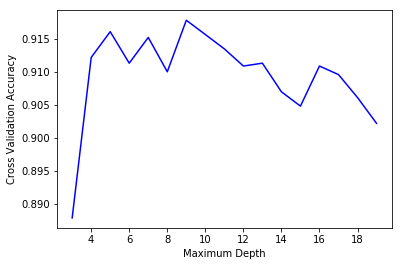

In [125]:
depth = []
tree_start = 3
tree_end   = 20
for i in range(tree_start,tree_end):
    dt = DecisionTreeClassifier(max_depth=i)
    # Perform 5-fold cross validation 
    scores = cross_val_score(estimator=dt, X=X_train, y=y_train, cv=5, n_jobs=-1)
    depth.append((i,scores.mean()))
plt.plot(np.array(depth)[:,0], np.array(depth)[:,1], 'b-')
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Maximum Depth")
plt.show()

As we can see, the optimal depth is found to be a depth of `best_depth`. Let us set this as a new parameter. Can you see why we coded the best depth parameter as we did below? (Hint: Think about reproducibility.)

In [126]:
best_depth = np.argmax(np.array(depth)[:,1]) + tree_start
best_depth

9

In [127]:
dt = DecisionTreeClassifier(max_depth=best_depth)

In [128]:
dt_fitted = dt.fit(X_train, y_train)

In [129]:
dt_fitted.score(X_test, y_test)

0.90873533246414606

In [130]:
expected = y_test
predicted = dt_fitted.predict(X_test)
conf_mat = confusion_matrix(expected, predicted)
conf_df = pd.DataFrame(conf_mat, columns = ['y_hat=0', 'y_hat = 1'], index = ['y=0', 'y=1'])
conf_df

,y_hat=0,y_hat = 1
y=0,1307,73
y=1,137,784


What results can you come up with based on the above procedures?

## What about the dropout method?

In [131]:
def dropout_function_forest(B, p, md=None):
    test_counts = np.zeros((y_test.shape[0], B))
    train_counts = np.zeros((y_train.shape[0], B))
    for i in range(B):
        train_set = X_train.copy()
        for column in train_set.columns:
            if np.random.uniform() < p:
                train_set[column] = 0
        test_counts[:,i] = (DecisionTreeClassifier(max_depth=md).fit(train_set, y_train)).predict(X_test)
        train_counts[:,i] = (DecisionTreeClassifier(max_depth=md).fit(train_set, y_train)).predict(X_train)
    y_hat = (np.mean(test_counts,axis=1)>.5).astype(float)
    y_hat_train = (np.mean(train_counts,axis=1)>.5).astype(float)
    return (metrics.accuracy_score(y_test, y_hat), metrics.accuracy_score(y_train, y_hat_train))

In [132]:
dropout_function_forest(100, 0.5)

(0.94437201216862232, 0.99913043478260866)

# Part 2: Bagging and Random Forest Models

## Bagging Our Decsion Trees...

Bagging, or "Bootstrap Aggregating" implements the following procedure: 
1.	Create new datasets via bootstrapping
2.	Fit a decision tree
3.	Average the results across the generated trees (or use majority voting for classification). 

In [133]:
n_trees = 51 # Number of iterations

trees = []

for i in range(n_trees):
    dt = DecisionTreeClassifier(max_depth=best_depth,max_features=None, random_state=109)
    sample_index = np.random.choice(range(len(y_train)), size=len(y_train), replace=True)
    X_train_samples = X_train.values[sample_index]
    y_train_samples = y_train.values[sample_index]
    
    trees.append(dt.fit(X_train_samples, y_train_samples))


In [134]:
tree_preds = []
for tree in trees:
    tree_preds.append(tree.predict(X_test))

predicted = pd.DataFrame(np.array(tree_preds)).T.mode(axis=1)[0]

In [135]:
expected = y_test
conf_mat = confusion_matrix(expected, predicted)
conf_df = pd.DataFrame(conf_mat, columns = ['y_hat=0', 'y_hat = 1'], index = ['y=0', 'y=1'])
conf_df

,y_hat=0,y_hat = 1
y=0,1327,53
y=1,124,797


What’s the problem with just bagging?

## Random Forest

Now, we will fit an ensemble method, the Random Forest technique, which is different from the decision tree. Refer to the lectures slides for a full treatment on how they are different. 

In [136]:
train_scores = []
test_scores = []
trees = [2**x for x in range(7)]
for n_trees in trees:
    rf = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt')
    test_scores.append(metrics.accuracy_score(y_test, rf.fit(X_train, y_train).predict(X_test)))
    train_scores.append(metrics.accuracy_score(y_train, rf.fit(X_train, y_train).predict(X_train)))
    
trees

[1, 2, 4, 8, 16, 32, 64]

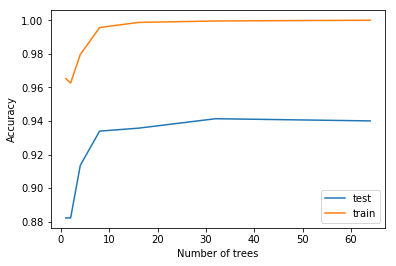

In [137]:
plt.plot(trees, test_scores, label='test')
plt.plot(trees, train_scores, label='train')
plt.legend(loc='best')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.show()

The number of trees represent the model complexity as the more trees there are. As we see, the test and training accuracy both improve (to a point) as the number of trees increase 

# Part 3: Fitting using the Adaboost technique

![](https://i.stack.imgur.com/0QPUi.png)
(Fig. stolen from R. Meir and G. Rätsch. An introduction to boosting and leveraging) 

We can then use the boosting method to compare against the Random Forest method.

In [138]:
accuracies_train = []
accuracies_test = []
trees = [2**x for x in range(7)]
for md in [1,2,10,None]:
    depth_accuracies_train = []
    depth_accuracies_test = []
    for n in trees:
        ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=md),n_estimators=n, learning_rate=.01)
        depth_accuracies_train.append(metrics.accuracy_score(y_train, ada.fit(X_train,y_train).predict(X_train)))
        depth_accuracies_test.append(metrics.accuracy_score(y_test, ada.fit(X_train,y_train).predict(X_test)))
    accuracies_train.append(depth_accuracies_train)
    accuracies_test.append(depth_accuracies_test)

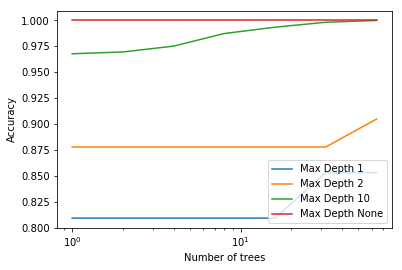

In [139]:
for i, md in enumerate([1,2,10,None]):
    plt.semilogx(trees, accuracies_train[i], label='Max Depth {}'.format(md))
plt.legend(loc=4)
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.show()

The same idea applies here. As our model complexity increases, we observe an increase in accuracy but as we go further to the right of the graph, our model will overfit the data. To formally understand what is going on here, we will give a brief treatment of how the bias and variance are related in the next section.

# Part 4: Back to The bias-variance tradeoff

<img src="https://raw.githubusercontent.com/albertw1/data/master/Low-High-Variances-Biases.png" width="300" height="300"/>

To map the idea above to our training error curves, consider the following plots. Notice that the y-axis plots the error. This can be converted to our earlier plots with accuracy by inverting the y-axis. Why is this the case? Because as your error increases, the accuracy decreases. There is an inverse relationship between the two.

<img src="https://raw.githubusercontent.com/albertw1/data/master/bias_variance_chart1.jpg" width="450" height="400"/>

In the top left plot, it represents the ideal situation we want to be in, where there is low bias and low variance. The **red** plot indicates the testing error while the **blue** plot indicates the training error. We see in the top left plot that we are generalizing well and our training error is low. 

In the top right plot, we have the case where our variance is low but the bias is high. Our model is not picking up the relevant features on the training set and is generalizing badly. 

In the bottom left plot, our high variance and low bias indicates that our model is not able to find a way to summarize the training data in such a way that generalizes well into new data.

In the bottom right plot, the high bias indicates that our model is unable to learn well from the training data and is unable to generalize well.

In general, high bias results when we are underfitting our model and high variance refers to the case when we are overfitting the model. 

## Plotting and understanding learning curves of the Random Forest and Adaboost methods:

Here, we will plot learning curves of the Adaboost classifier:

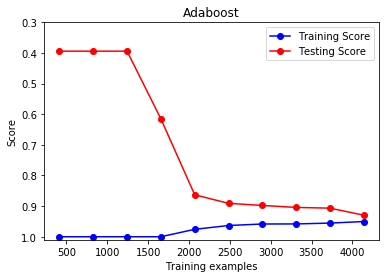

In [140]:
X = np.array(spam.iloc[:, spam.columns != 'Email'])
y = np.array(spam['Email'])

train_sizes, train_scores, test_scores = learning_curve(
    AdaBoostClassifier(), X, y, cv=10, n_jobs=-1, train_sizes=np.linspace(.1, 1., 10), verbose=0)
 
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Adaboost")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim((0.3, 1.01))
plt.gca().invert_yaxis()
 
# Plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Test score")
plt.legend(['Training Score', 'Testing Score'], loc = 1)

Now, we will do the same for the Random Forest classifer:

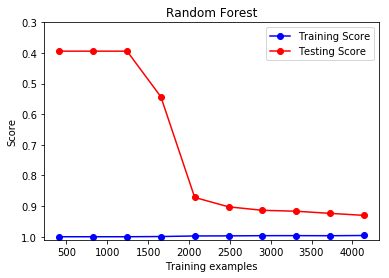

In [141]:
X = np.array(spam.iloc[:, spam.columns != 'Email'])
y = np.array(spam['Email'])

train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(), X, y, cv=10, n_jobs=-1, train_sizes=np.linspace(.1, 1., 10), verbose=0)
 
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
 
plt.figure()
plt.title("Random Forest")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim((0.3, 1.01))
plt.gca().invert_yaxis()
 
# Plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Test score")
plt.legend(['Training Score', 'Testing Score'], loc = 1)

The takeaway here is that as we increase the number of training examples we wish to use, the testing score converges to that of the training score. Which of the following 4 plots above do these plots look like in general? These plots indicate that our models are low variance and low bias producing and that the two models generalize well to new data. In summary, plotting these curves give us a rough idea of how appropriate our models are for the data. 

# Part 5: Fitting it all together

**Bagging** or bootstrap aggregation, is a technique for reducing the variance of an estimated prediction function. **Bagging** typically works especially well for high-variance, low-bias procedures, such as trees. For regression, we simply fit the same regression tree many times to bootstrap- sampled versions of the training data, and average the result. For classifi- cation, a committee of trees each cast a vote for the predicted class. Bagging results in correlated trees.

**Boosting** is similar to bagging, but unlike bagging, the committee of weak learners evolves over time, and the members cast a weighted vote. **Boosting** appears to dominate bagging on most problems, and has become the preferred choice between the two.

**Random Forests** is a substantial modification of bagging that builds a large collection of de-correlated trees, and then averages them. On many problems the performance of random forests is very similar to boosting, and they are simpler to train and tune. As a consequence, random forests are popular, and are used quite often in practice.

The essential idea in **Bagging** is to average many noisy but approximately unbiased models, and hence reduce the variance. Trees are ideal candidates for bagging, since they can capture complex interaction structures in the data, and if grown sufficiently deep, have relatively low bias. Since trees are notoriously noisy, they benefit greatly from the averaging. Moreover, since each tree generated in bagging is identically distributed (i.d.), the expectation of an average of B such trees is the same as the ex- pectation of any one of them. This means the bias of bagged trees is the same as that of the individual trees, and the only hope of improvement is through variance reduction. This is in contrast to **Boosting**, where the trees are grown in an adaptive way to remove bias, and hence are not i.d.

The idea in **Random Forests** is to improve the variance reduction of bagging by reducing the correlation between the trees, without increasing the variance too much. This is achieved in the tree-growing process through random selection of the input variables. Before each split, select $m \leq p$ of the input variables at random as candidates for splitting.

**Decision trees** involve the greedy selection of the best split point from the dataset at each step.

This algorithm makes **Decision Trees** susceptible to high variance if they are not pruned. This high variance can be harnessed and reduced by creating multiple trees with different samples of the training dataset (different views of the problem) and combining their predictions. This approach is called bootstrap aggregation or **Bagging** for short.

A limitation of **Bagging** is that the same greedy algorithm is used to create each tree, meaning that it is likely that the same or very similar split points will be chosen in each tree making the different trees very similar (trees will be correlated). This, in turn, makes their predictions similar, mitigating the variance originally sought.

We can force the decision trees to be different by limiting the features (rows) that the greedy algorithm can evaluate at each split point when creating the tree. This is the **Random Forest** method mentioned above.

Like **Bagging**, multiple samples of the training dataset are taken and a different tree trained on each. The difference is that at each point a split is made in the data and added to the tree, only a fixed subset of attributes can be considered.